In [1]:
image_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeA/211114_P36_N2/211114_P36_N2_FlipV_R272_clahe.tif'
mask_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeA/211114_P36_N2/211114_P36_N2_FlipV_R277_JE_mask.tif'
cols_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeA/211114_P36_N2/211114_P36_N2_FlipV_R272_ColRois.zip'
save_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeA/211114_P36_N2/'
save_name = '211114_P36_N2'

if save_path[-1] != '/':
    save_path += '/'

##
start_im = 2 ### index of the first timepoint to include (0 is the first)
start_age = 37
entry_point = (0,27,290,245) #entry point of the neuron (T,Z,Y,X), where Z=0
stab_limit = 5 #(No. of timepoints for stable branches calculation)
nor_fact = 1 #this is for normalizing Col_occpancy. for now there is no other option, like neuron max

if save_path[-1] != '/':
    save_path += '/'

In [2]:
#imports
import utils.analysis as analysis
import matplotlib.pyplot as plt
import tifffile as tif
import numpy as np
from tqdm import tqdm
import pandas as pd
from read_roi import read_roi_zip as col_zip

In [3]:
neuron = tif.imread(image_path)

In [4]:
# do this step if you want to mask your neuron
mask = tif.imread(mask_path)
neuron[mask==0] = 0

In [5]:
# make all images binary
neuron = neuron[start_im:]
neuron[neuron != 0] = 1
# Cols = Cols - Cols.min()
# Cols[Cols!=0] = 1 

In [6]:
Cols = col_zip(cols_path)
## you might want to subset either neuron, Columns or both
# neuron = neuron[:,:40]


In [7]:
lifetimes = analysis.cal_lifetimes(neuron, save=False, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)
stable_neuron = analysis.stable_N(lifetimes, stab_limit=stab_limit, save=True, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)
# in case you want to save the neuron
# stable_neuron = stable_neuron.astype('uint16')
# tif.imwrite(save_path+'stable'+save_name, stable_neuron, imagej=True, resolution=(1./0.076, 1./0.076),
#                 metadata={'spacing': 0.4, 'unit': 'um', 'finterval': 1/10,'axes': 'TZYX'})                                    
output_results = analysis.N_volume(neuron, stable_neuron, normalize=False, 
                                start_t=start_age, plot=False, 
                                save=False, save_path=save_path, 
                                save_file='Vol_'+save_name)
output_results['growthR_all'] = output_results.vol_all.diff()/output_results.vol_all
output_results['growthR_stable'] = output_results.vol_stable.diff()/output_results.vol_stable
output_results['trans_per'] = (output_results.vol_all - output_results.vol_stable)/output_results.vol_stable
DGIs = analysis.calculate_DGI(entry_point, neuron, 
                                start_t=start_age, 
                                save=True, save_path='', 
                                save_file='')
output_results = pd.merge(output_results, DGIs, on='timepoints')

100%|██████████| 91/91 [04:08<00:00,  2.73s/it]


In [12]:
in_col = np.zeros_like(neuron)
for col, Roi in Cols.items():
    masked_nD, Roi_3D = analysis.roi_img(neuron, Roi)
    in_col =  in_col + masked_nD
# out_col = neuron - in_col
output_results['size_in_cols'] = in_col.sum(axis=(1,2,3))
# output_results['size_out_cols'] = out_col.sum(axis=(1,2,3))

In [8]:
output_file = save_path+save_name+'_output.csv'
output_file = output_file.replace('.tif','')
output_results.to_csv(output_file, sep=';')

In [9]:
# calculate columns' occupancy
# define the neuron and saving name
cols_hist = analysis.col_occupancy(neuron, cols_zip=Cols, norm_cols=Cols, 
                                    normalize_cols=True, nor_fact=nor_fact, 
                                    start_t=start_age, 
                                    plot=True, save=True, 
                                    save_path=save_path, 
                                    save_file='all_px_'+save_name)

cols_hist = analysis.col_occupancy(stable_neuron, cols_zip=Cols, norm_cols=Cols, 
                                    normalize_cols=True, nor_fact=nor_fact, 
                                    start_t=start_age, 
                                    plot=True, save=True, 
                                    save_path=save_path, 
                                    save_file='stab_px_'+save_name)

NameError: name 'Cols' is not defined

In [8]:
output_results.head()

,timepoints,vol_all,vol_stable,growthR_all,growthR_stable,trans_per,ori_vec,Max_Vec_length,av_vect,av_vect_length,ori_vec_deg,deg_variance,PC_std,DGI,y_spread,x_spread
0,37.00,150244,0,NaN,NaN,inf,"[2198767, 6442379, 2047385]",8.465959e+06,"[14.634640983999361, 42.87944277308911, 13.627...",47.312961,73.260562,650.072440,27.639321,0.839655,187,113
1,37.25,136253,0,1.353860e+14,NaN,inf,"[2009905, 5688710, 1665516]",7.339899e+06,"[14.751271531636, 41.7510807101495, 12.2237014...",45.936604,74.567712,538.737529,25.569732,0.852737,154,92
2,37.50,151469,0,1.004562e-01,NaN,inf,"[2361864, 7314780, 2028230]",9.172259e+06,"[15.593052043652497, 48.2922578217325, 13.3903...",52.484171,75.218587,439.046683,29.325334,0.866714,190,83
3,37.75,145275,0,1.269781e+14,NaN,inf,"[2266294, 6415537, 1639377]",8.191638e+06,"[15.600027533987266, 44.16132851488556, 11.284...",48.176001,76.453295,487.278486,26.953281,0.854380,185,85
4,38.00,132612,80601,1.391031e+14,1.0,0.64529,"[1940801, 6433299, 1427165]",7.821977e+06,"[14.635183844599283, 48.5121934666546, 10.7619...",51.801943,78.009351,525.262776,28.103825,0.878238,160,119


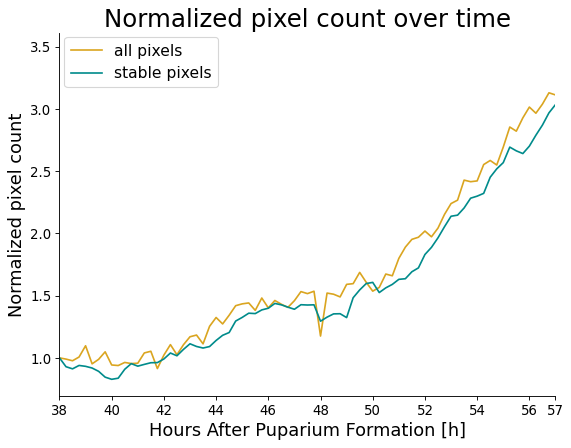

In [35]:
import seaborn as sns
fig_name = save_path+save_name+'_volume.pdf'
plt.figure(figsize=(8, 6), dpi=80)
y = output_results.vol_all[4:]/output_results.vol_all[4:][4]
y1 = output_results.vol_stable[4:]/output_results.vol_stable[4:][4]
plt.plot(output_results.timepoints[4:],y, label='all pixels', c='goldenrod')
# a, b = np.polyfit(output_results.timepoints[4:],y, 1)
# plt.plot(output_results.timepoints[4:], a*output_results.timepoints[4:]+b, c='red', linestyle='dashdot', linewidth=1)
plt.plot(output_results.timepoints[4:],y1, label='stable pixels', c='darkcyan')
# a, b = np.polyfit(output_results.timepoints[4:],y1, 1)
# plt.plot(output_results.timepoints[4:], a*output_results.timepoints[4:]+b, c='black', linestyle='dashdot', linewidth=1)
plt.legend(bbox_to_anchor=(.01, .99), loc=2, borderaxespad=0., prop={'size': 14})
plt.title('Normalized pixel count over time', fontsize=22)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(38,57)
x_range1 = list(np.arange(38,58,2))
x_range1.append(57)
plt.xticks(x_range1)
sns.despine()
plt.ylabel('Normalized pixel count', fontsize=16)
plt.xlabel("Hours After Puparium Formation [h]", fontsize=16)
plt.savefig(fig_name, bbox_inches='tight')

In [17]:
y[4]

0.28788704386732344

In [10]:
# run this if you already calculated stable_neuron
# stable_n = tif.imread(stable_path)

# or calculate stable pixels with the following command
lifetimes = analysis.cal_lifetimes(neuron, save=False, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)
stable_neuron = analysis.stable_N(lifetimes, stab_limit=stab_limit, save=False, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)

stable_neuron[stable_neuron !=0] = 1

# in case you want to save the neuron
stable_neuron = stable_neuron.astype('uint16')
tif.imwrite(save_path+'stable'+save_name, stable_neuron, imagej=True, resolution=(1./0.076, 1./0.076),
                metadata={'spacing': 0.4, 'unit': 'um', 'finterval': 1/10,'axes': 'TZYX'})

100%|██████████| 92/92 [00:04<00:00, 22.43it/s]


In [6]:
# stable_neuron[stable_neuron !=0] = 1
# transient = neuron - stable_neuron
# tif.imwrite(save_path+'trans'+save_name, transient, imagej=True, resolution=(1./0.076, 1./0.076),
#                 metadata={'spacing': 0.4, 'unit': 'um', 'finterval': 1/10,'axes': 'TZYX'})

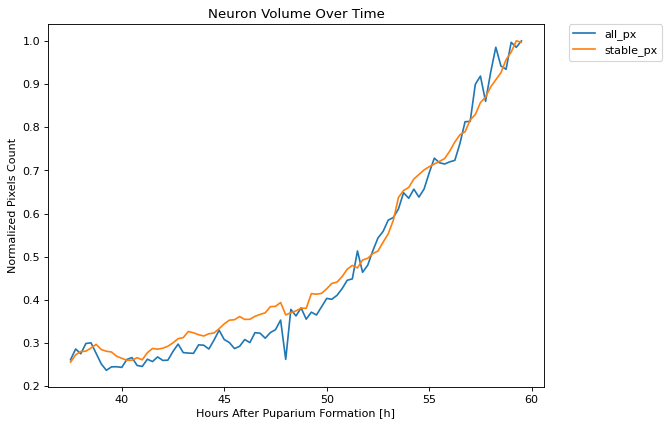

In [9]:
fig_name = save_path+save_name+'_Volume.pdf'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(output_results.timepoints[4:],output_results.vol_all[4:]/output_results.vol_all.max(), label='all_px')
plt.plot(output_results.timepoints[4:],output_results.vol_stable[4:]/output_results.vol_stable.max(), label='stable_px')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Neuron Volume Over Time')
plt.ylabel('Normalized Pixels Count')
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig(fig_name, bbox_inches='tight')




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


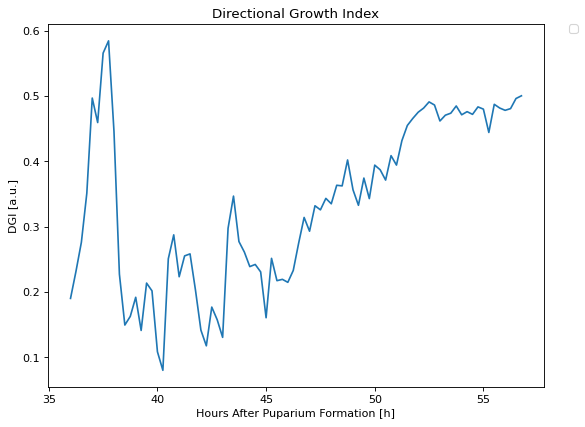

In [ ]:
fig_name = save_path+save_name+'_DGI.pdf'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(output_results.timepoints,output_results.DGI)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Directional Growth Index')
plt.ylabel('DGI [a.u.]')
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig(fig_name, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


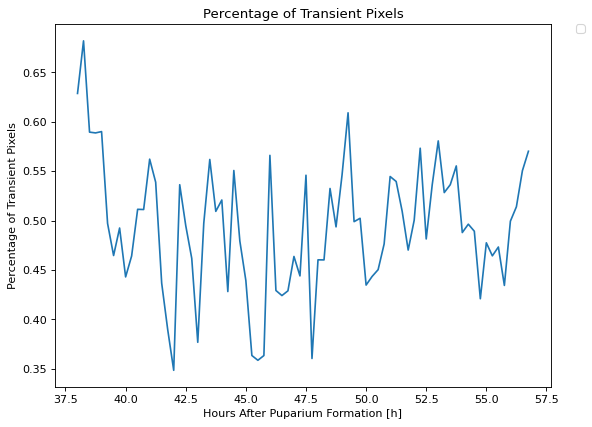

In [13]:
fig_name = save_path+save_name+'_trans_per.pdf'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(output_results.timepoints[8:],output_results.trans_per[8:])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Percentage of Transient Pixels')
plt.ylabel('Percentage of Transient Pixels')
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig(fig_name, bbox_inches='tight')